iタスク,anyモデルについて可視化する関数を用意する  
データのpathはこの階層のconfigに用意しておく
モデルの設定を上手くやるとepochの増加に対する精度の比較が楽にやれる  
これを全タスクについてやる上位関数を作る  
所定のパス(この階層のconfig)に画像を保存する関数を別に用意しておく  

In [1]:
import os, sys
import json
PATH_CUR = os.path.dirname(os.path.realpath("__file__"))
sys.path.append(PATH_CUR)
with __import__('importnb').Notebook(): 
    from score_store import ScoreStoringLoader
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np



In [62]:
def vis_oneimg(data_dic,vis_model_param,xy_width,png_path,save):
    fig1 = plt.figure()

    xlabel,ylabel="iter","accuracy_train"
    ax1 = fig1.add_subplot(111)
    ax1.set_xlabel(xlabel,fontsize=14)
    ax1.set_ylabel(ylabel,fontsize=14)

    if xy_width[0] !=False:
        ax1.set_xlim(xy_width[0][0],xy_width[0][1] )
    if xy_width[1] !=False:
        ax1.set_ylim(xy_width[1][0],xy_width[1][1] )

    batch_size=0
    handles=[]
    labels=[]
    for modeldir,data_bs in data_dic.items():
        p_s=[]
        for k,v in data_bs.items():
            if k=="batch_size":batch_size=v
            else:
                x=v[xlabel]
                y=v[ylabel]
                ##ax1.plot(x,y,color=vis_model_param[modeldir]["color"],marker=".",label=vis_model_param[modeldir]["modellabel"],markersize=4) #ls linestyle
                p,=ax1.plot(x,y,color=vis_model_param[modeldir]["color"],marker=".",markersize=4) #ls linestyle
                p_s.append(p)
        handles.append(tuple(p_s))
        labels.append(vis_model_param[modeldir]["modellabel"])

    ##handles, labels = ax1.get_legend_handles_labels()
    ##fig1.legend(handles, labels,title="models",bbox_to_anchor=(0, -0.01), loc='upper left', borderaxespad=0,fontsize=10)
    fig1.legend(handles, labels,title="models",bbox_to_anchor=(0, -0.01), loc='upper left', borderaxespad=0,fontsize=10)

    #plt.legend(h1+h2, l1+l2)
    fig1.suptitle('batch_size = '+str(batch_size))

    if save:
        fig1.savefig(png_path,bbox_inches="tight")


In [57]:
def vis_associative(filename):
    vis_model_param={"ntm":{"modellabel":"basicNTM","color":"blue"},
                    "rrnn":{"modellabel":"memory + R-RNN","color":"green"},
                    "sortrrnn":{"modellabel":"sort + R-RNN","color":"orange"}
                    }
    modeldir_list=vis_model_param.keys()
    savescore_dir ="/work/handmade_utils/sotsuron_scores/ntm_vlgiitr/associative"
    fileid="v1228"
    runid_list=range(1,6)

    ssl=ScoreStoringLoader(savescore_dir,modeldir_list,fileid,runid_list)
    data_dic =ssl.get_data_dic()
    xy_width=([0,12000],False)
    savedir="saved_imgs/ntm_vlgiitr/associative"
    png_path=os.path.join(savedir,filename)
    vis_oneimg(data_dic,vis_model_param,xy_width,png_path,save=True)

def vis_priority(filename):
    vis_model_param={"ntm":{"modellabel":"basicNTM","color":"blue"},
                    "rrnn":{"modellabel":"memory + R-RNN","color":"green"},
                    "sortrrnn":{"modellabel":"sort + R-RNN","color":"orange"}
                    }
    modeldir_list=vis_model_param.keys()
    savescore_dir ="/work/handmade_utils/sotsuron_scores/ntm_vlgiitr/priority"
    fileid="v1228"
    runid_list=range(1,3)

    ssl=ScoreStoringLoader(savescore_dir,modeldir_list,fileid,runid_list)
    data_dic =ssl.get_data_dic()

    xy_width=(False,False)
    savedir="saved_imgs/ntm_vlgiitr/priority"
    png_path=os.path.join(savedir,filename)
    vis_oneimg(data_dic,vis_model_param,xy_width,png_path,save=False)
def vis_nth(filename):
    vis_model_param={#"ntm":{"modellabel":"basicNTM","color":"blue"},
                    #"rrnn":{"modellabel":"memory + R-RNN","color":"green"},
                    #"sortrrnn":{"modellabel":"sort + R-RNN","color":"orange"}
                    "santoro_rrnn":{"modellabel":"original R-RNN","color":"purple"}
                    }
    modeldir_list=vis_model_param.keys()
    savescore_dir ="/work/handmade_utils/sotsuron_scores/ntm_vlgiitr/nth"
    fileid="v1229"
    runid_list=range(1,3)

    ssl=ScoreStoringLoader(savescore_dir,modeldir_list,fileid,runid_list)
    data_dic =ssl.get_data_dic()

    xy_width=(False,False)
    savedir="saved_imgs/ntm_vlgiitr/nth"
    png_path=os.path.join(savedir,filename)
    vis_oneimg(data_dic,vis_model_param,xy_width,png_path,save=False)

run_ids: range(1, 3)


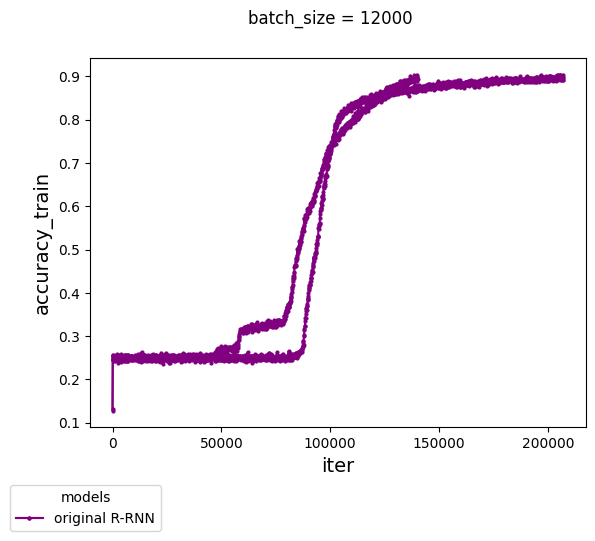

In [63]:
#vis_associative("v1228_0-12000.png")
#vis_priority("v1228_id12.png")
vis_nth("original_id12")
#vis_babi()

過去のコード。ベースラインやbabiを可視化するときは参考になるか

In [71]:
class OldScoreStoringLoader(): 
    #data_config["savescore_dir"],data_config["filename_common"]
    def __init__(self,savescore_dir,filename_common,fileid_list,desc_lines=1,sep=":"):
        self.desc_lines =desc_lines
        self.sep=sep
        self.data_dic={} #{"rrnn":
                            #{"batch_size":1600,
                            # "runid1":{"epoch":[0,10,20...]  , "accuracy":[0.7,0.8,0.9 ...]  , "z"...}  
                            #}, "sortrrnn":...}

        modeldir ="SAM+dnc_model"
        self.data_dic[modeldir] ={}
        for idx,fileid in enumerate( fileid_list):
            data_path=os.path.join(savescore_dir,filename_common+fileid+".txt")
            with open(data_path, "r" , encoding= "utf-8" ) as f:
                filecontent=f.read().splitlines()
                #file_description=json.loads(filecontent[0])
                lines=filecontent[desc_lines:]

                listed_data = [line.split(self.sep) for line in lines]
                listed_data = np.array([[float(data) for data in line] for line in listed_data])
                self.data_dic[modeldir][fileid] ={"iteration":listed_data[:,0],"error rate":listed_data[:,1]}

    def get_data_dic(self): 
        return self.data_dic

In [73]:
fileid_str_list =[str(i) for i in range(1,21)]
fileid_str_list.append("mean")
oss=OldScoreStoringLoader("SAM+dnc_model","task",fileid_str_list)
df=pd.DataFrame(oss.get_data_dic()).reindex(index=fileid_str_list)
df

,SAM+dnc_model
1,"{'iteration': [0.0, 1.0, 2.0, 3.0, 4.0, 5.0, 6..."
2,"{'iteration': [0.0, 1.0, 2.0, 3.0, 4.0, 5.0, 6..."
3,"{'iteration': [0.0, 1.0, 2.0, 3.0, 4.0, 5.0, 6..."
4,"{'iteration': [0.0, 1.0, 2.0, 3.0, 4.0, 5.0, 6..."
5,"{'iteration': [0.0, 1.0, 2.0, 3.0, 4.0, 5.0, 6..."
6,"{'iteration': [0.0, 1.0, 2.0, 3.0, 4.0, 5.0, 6..."
7,"{'iteration': [0.0, 1.0, 2.0, 3.0, 4.0, 5.0, 6..."
8,"{'iteration': [0.0, 1.0, 2.0, 3.0, 4.0, 5.0, 6..."
9,"{'iteration': [0.0, 1.0, 2.0, 3.0, 4.0, 5.0, 6..."
10,"{'iteration': [0.0, 1.0, 2.0, 3.0, 4.0, 5.0, 6..."


In [66]:
def get_multiSSasDF(readSS_config,fileid_str_list):
    dir_data_dic ={}
    for dirname in readSS_config["read_directories"]:
        ssl=ScoreStoringLoader(dirname,readSS_config["filename_common"],fileid_str_list,vals=["step","bitError"])
        dir_data_dic[dirname] =ssl.get_data_dic()
    df=pd.DataFrame(dir_data_dic).reindex(index=fileid_str_list)
    return df

In [76]:
with open("./config_sotsuron.json", "r") as fp:
    config = json.load(fp)
readSS_config=config["read_ScoreStoring"]
vis_config =config["visualization"]
baseline_config =vis_config["baselines"]

fileid_str_list =[str(i) for i in range(1,21)]
fileid_str_list.append("mean")
#fileid_str_list =["","2","_Adam_clip50"]
#fileid_str_list=readSS_config["fileid_list"]

accSequence_df =get_multiSSasDF(readSS_config,fileid_str_list)
accSequence_df

TypeError: __init__() got an unexpected keyword argument 'vals'

In [74]:
class BaselinesLoader(): 
    #data_config["savescore_dir"],data_config["filename_common"]
    def __init__(self,filename_list,baseline_dir="/work/handmade_utils/sotsuron_scores/baseline_scores",desc_lines=1,sep=":",vals=["taskid","accuracy"]):
        self.desc_lines =desc_lines
        self.sep=sep
        print("read_baseline_files:",filename_list)

        self.filename_list =filename_list
        self.data_dic={} 

        self.filepath_dic ={}
        for filename in filename_list:
            self.filepath_dic[filename] =os.path.join(baseline_dir,filename+".txt")

        for filename,path in self.filepath_dic.items():
            with open(path, "r" , encoding= "utf-8" ) as f:
                lines=f.read().splitlines()[self.desc_lines:]
                listed_data = [line.split(self.sep) for line in lines] #[["mean" , "0.83"], ...]
                self.data_dic[filename] ={line[0]:float(line[1]) for line in listed_data} #{"mean" : 0.83 , "1": ...}

    def get_data_dic(self): 
        return self.data_dic

In [79]:
baselinesloader =BaselinesLoader(["lstm_grave"])
bases =baselinesloader.get_data_dic()
bases['lstm_grave'] = {k:1-v for k,v in bases['lstm_grave'].items() }
print(bases)

read_baseline_files: ['lstm_grave']
{'lstm_grave': {'1': 0.28400000000000003, '2': 0.56, '3': 0.513, '4': 0.008000000000000007, '5': 0.03200000000000003, '6': 0.15200000000000002, '7': 0.16400000000000003, '8': 0.17700000000000005, '9': 0.15400000000000003, '10': 0.28700000000000003, '11': 0.122, '12': 0.05400000000000005, '13': 0.07199999999999995, '14': 0.5589999999999999, '15': 0.47, '16': 0.5329999999999999, '17': 0.348, '18': 0.050000000000000044, '19': 0.909, '20': 0.013000000000000012, 'mean': 0.273}}


In [100]:
lstmbase=bases['lstm_grave']
for task,data in lstmbase.items():
    print(task+":"+str(np.round(data*100,decimals=1)))

1:28.4
2:56.0
3:51.3
4:0.8
5:3.2
6:15.2
7:16.4
8:17.7
9:15.4
10:28.7
11:12.2
12:5.4
13:7.2
14:55.9
15:47.0
16:53.3
17:34.8
18:5.0
19:90.9
20:1.3
mean:27.3


In [96]:
for task,data in df.iterrows():
    y=1-data["SAM+dnc_model"]["error rate"]
    mini=np.min(y)
    mini=np.round(mini*100,decimals=1)
    print(task+":"+str(mini))

1:44.4
2:53.6
3:53.9
4:20.2
5:35.1
6:16.6
7:18.2
8:21.2
9:18.9
10:33.9
11:29.2
12:27.5
13:6.1
14:47.3
15:42.8
16:48.9
17:36.9
18:5.7
19:90.6
20:2.6
mean:34.4


/tmp/ipykernel_3150842/3540165107.py:12: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  fig1 = plt.figure()


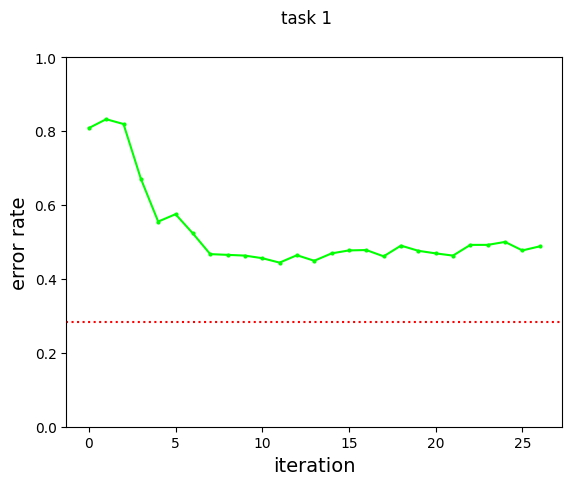

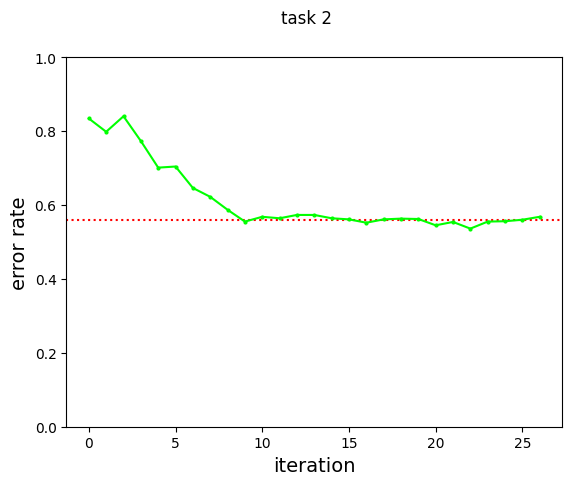

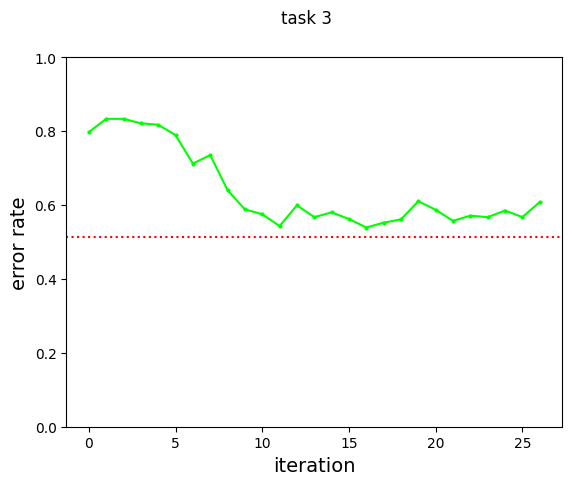

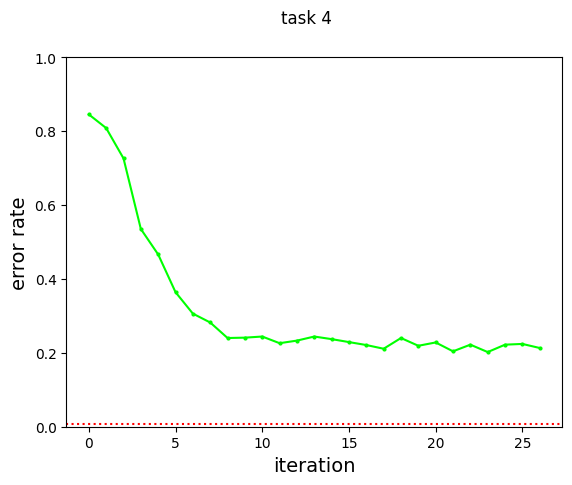

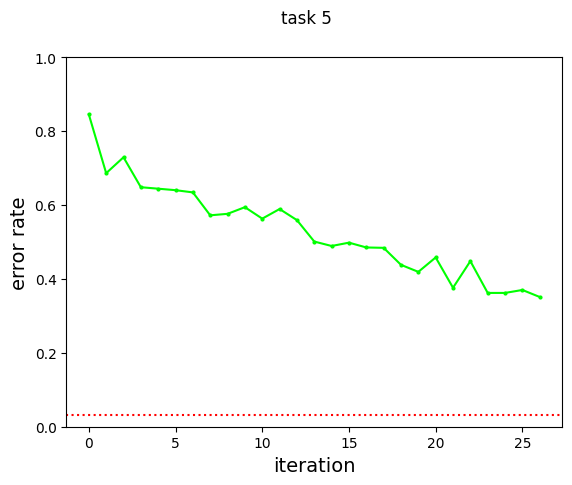

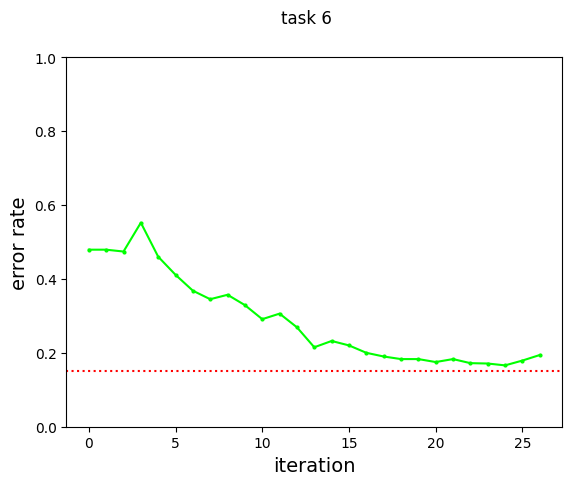

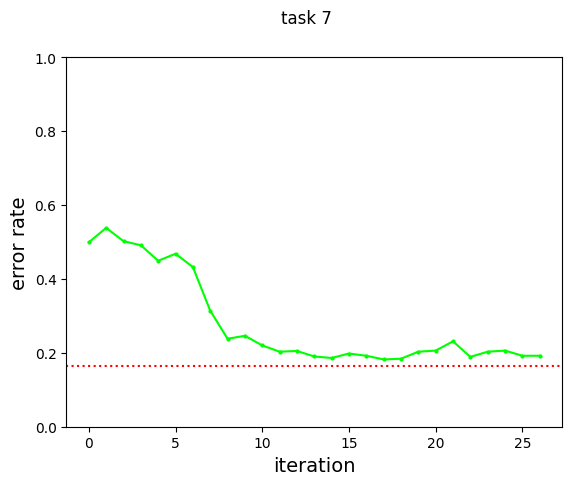

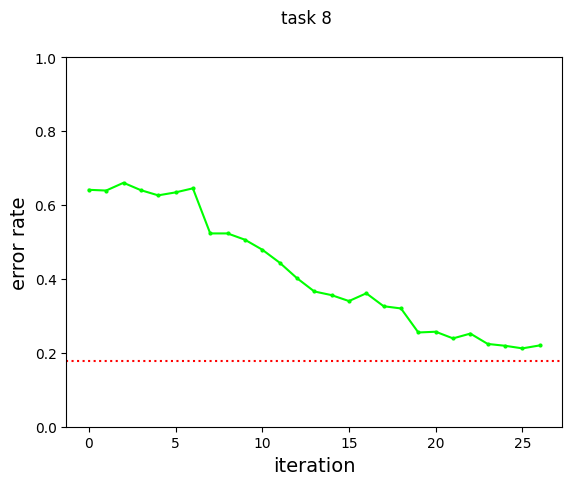

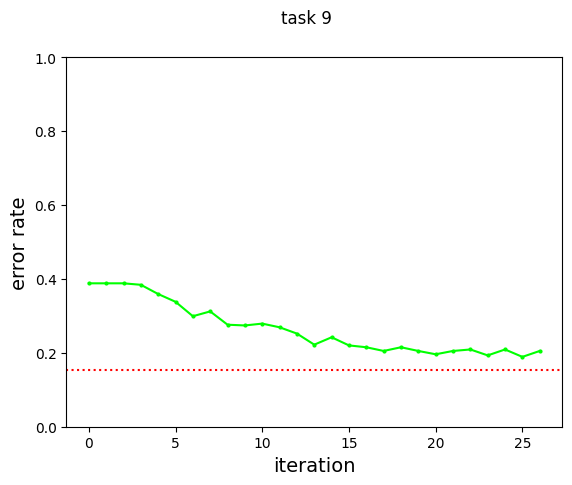

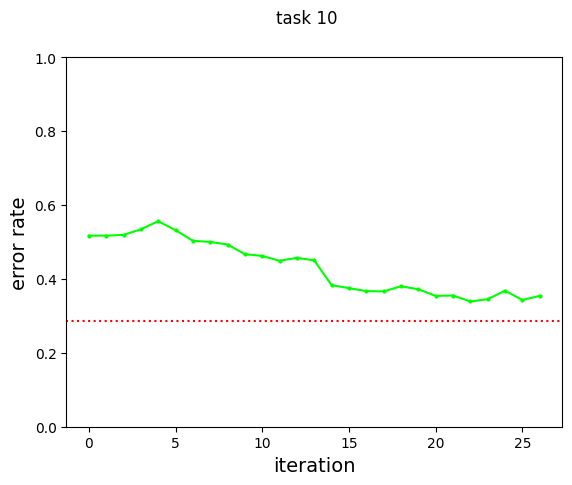

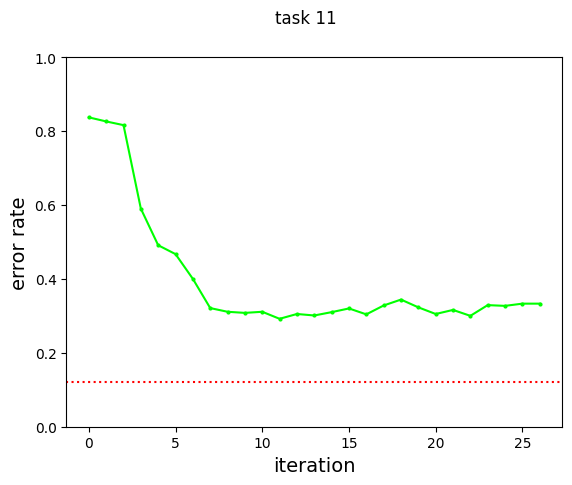

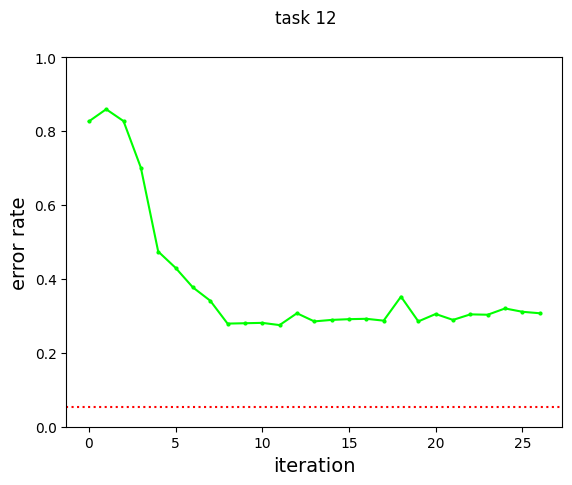

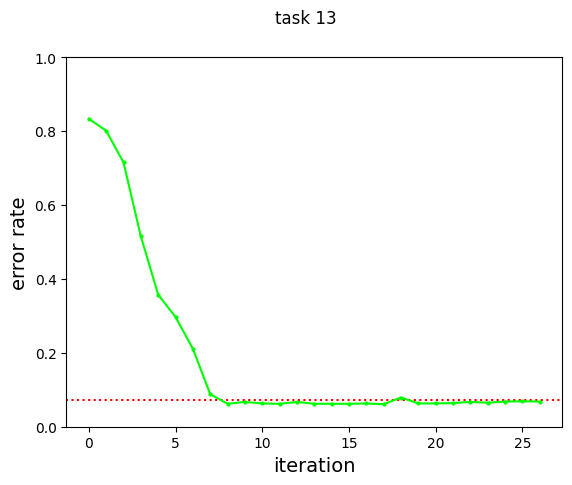

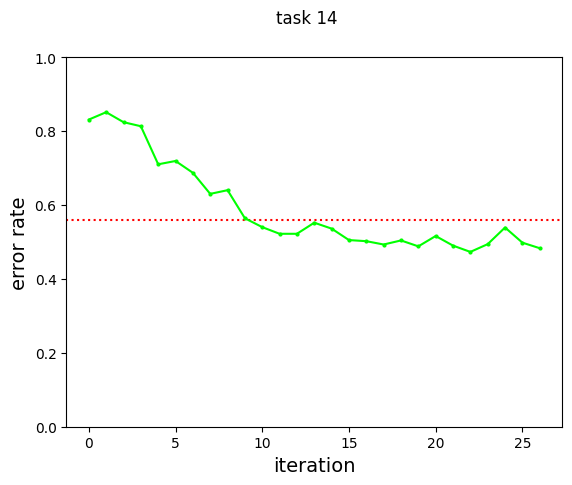

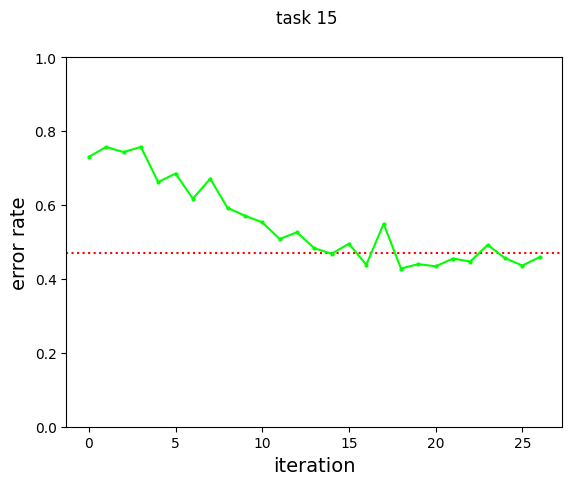

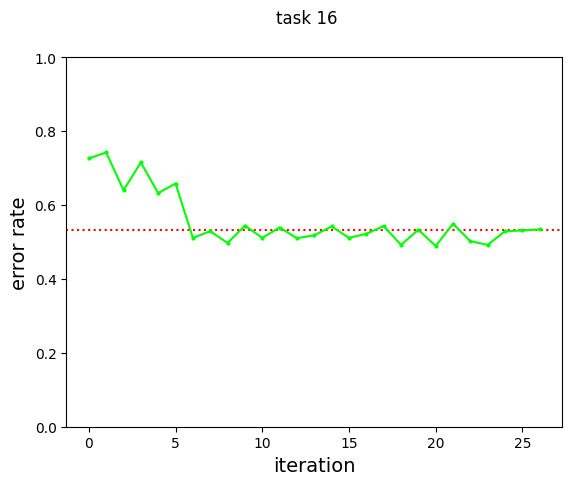

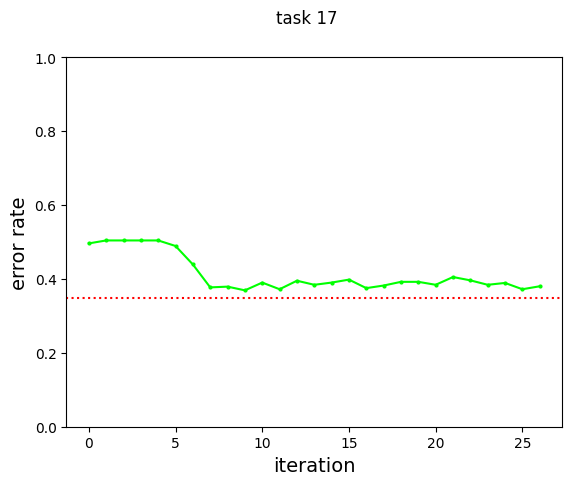

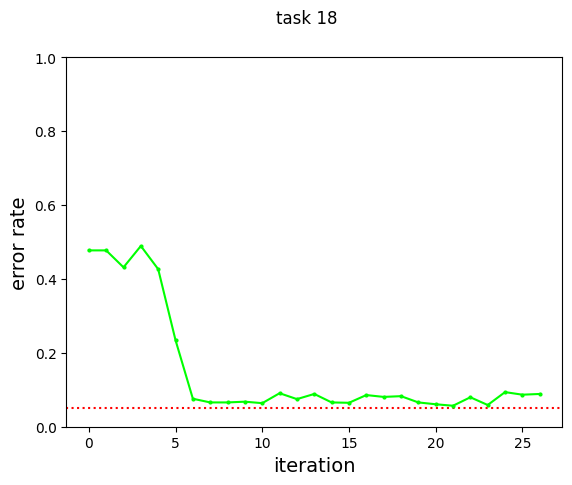

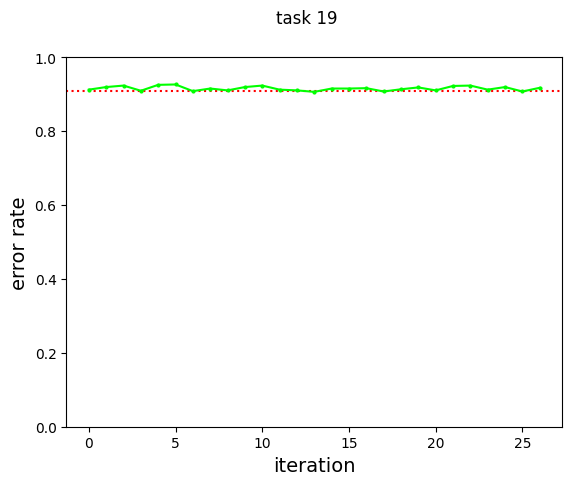

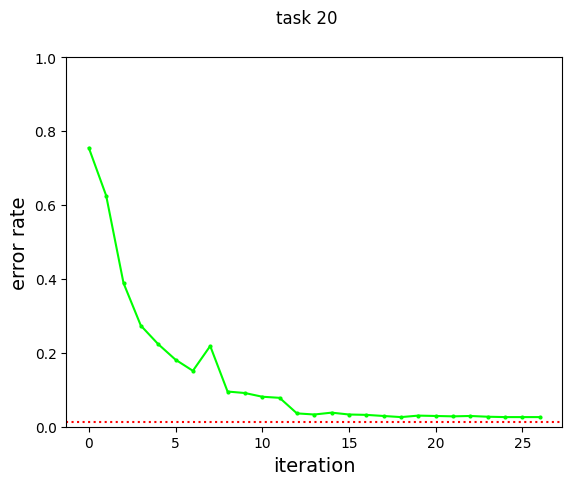

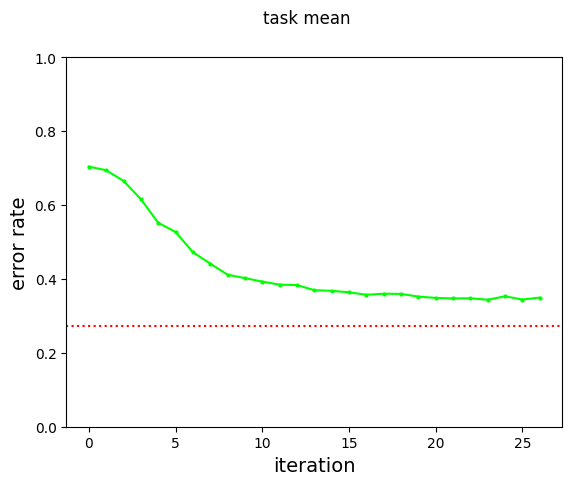

In [97]:
xlabel,ylabel="iteration","error rate"

#bases =baselinesloader.get_data_dic()
#bases['lstm_grave'] = {k:1-v for k,v in bases['lstm_grave'].items() }

for task,data in df.iterrows():
    #print(task,data)
    #print(data["SAM+dnc_model"][ylabel])
    #print(1-data["SAM+dnc_model"][ylabel])
    png_path=os.path.join("saved_imgs/tokuron","task_"+task+".png")

    fig1 = plt.figure()

    ax1 = fig1.add_subplot(111)
    #ax1.set_xlim(left=0)
    ax1.set_ylim(0, 1)
    ax1.set_xlabel(xlabel,fontsize=14)
    ax1.set_ylabel(ylabel,fontsize=14)

    ##for ind_base,base_name in enumerate(baseline_config["filenames"]):
    ##    ax1.axhline(y=bases[base_name][task],color=baseline_config["base_colors"][ind_base]) #~label
    ax1.axhline(y=bases["lstm_grave"][task],color="red",linestyle="dotted") #~label
    

    #for ind,label in enumerate(readSS_config["read_directories"]):
    for ind,label in enumerate(["SAM+dnc_model"]):
        x=data[label][xlabel]
        y=1-data[label][ylabel]

        #ax1.plot(x,y,marker=".",label=vis_config["model_labels"][ind],markersize=4) #ls linestyle
        ax1.plot(x,y,color='lime',marker=".",label="PE+LSTM",markersize=4,) #ls linestyle
    handles, labels = ax1.get_legend_handles_labels()
    #fig1.legend(handles, labels,title="models",fontsize=13,loc='upper left')
    #plt.legend(h1+h2, l1+l2)
    fig1.suptitle('task '+task)
    
    fig1.savefig(png_path,bbox_inches="tight")